# Libraries

In [20]:
!pip install albumentations pytorch-metric-learning opencv-python tqdm

In [21]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm
from torchvision import models
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.cuda import amp
from torch.optim import lr_scheduler
import torch.nn.functional as F
from pytorch_metric_learning import losses
import math

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [23]:

class Network(nn.Module):
    def __init__(self, emb_dim=128):
        super(Network, self).__init__()

        base_model = models.resnet50(pretrained=True)

        # Bỏ layer cuối cùng (fc)
        self.backbone = nn.Sequential(*list(base_model.children())[:-1])  # Output: [B, 2048, 1, 1]

        # FC Head
        self.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.PReLU(),
            nn.Linear(512, emb_dim)
        )

    def forward(self, x):
        x = self.backbone(x)           # [B, 2048, 1, 1]
        x = torch.flatten(x, 1)        # [B, 2048]
        x = self.fc(x)                 # [B, emb_dim]
        return x

# Transform data

In [24]:
data_transform = A.Compose([
        A.Resize(224, 224),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)

In [25]:
test_path = "logo_verify_test"

In [26]:
model = Network(256).to(device)

checkpoint = torch.load("SupConLoss_BBModel2\Model2\SupConLoss_BBResNet50.pth", map_location=device, weights_only= False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


c:\Users\DELL\miniconda3\envs\yolo-world\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DELL\miniconda3\envs\yolo-world\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Network(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64,

# Hàm lấy vector embedding đầu ra của model cho 1 ảnh

In [27]:
def get_model_output(image_path, model):
    # Đọc ảnh
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Dùng Albumentations để augment và chuyển về tensor
    transformed = data_transform(image=image)
    image_tensor = transformed['image'].unsqueeze(0).to(device)  # Thêm batch dimension

    # Dự đoán
    with torch.no_grad():
        output = model(image_tensor)
    
    return output

In [28]:
image_path = r"logo_verify_test\amazon\000000.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Dùng Albumentations để augment và chuyển về tensor
transformed = data_transform(image=image)
image_tensor = transformed['image'].unsqueeze(0).to(device)  # Thêm batch dimension

# out = model(image_tensor)
print(image_tensor.shape)

torch.Size([1, 3, 224, 224])


# Cosine similarity của 2 vector đầu ra model

In [29]:
def cosine_similarity(image_path_1, image_path_2):
    output_1 = get_model_output(image_path_1, model)
    output_2 = get_model_output(image_path_2, model)
    cosine_sim = F.cosine_similarity(output_1, output_2)
    return cosine_sim.item()

In [30]:
image_path_1 = r"logo_verify_test\amazon\000000.png"
image_path_2 = r"logo_verify_test\oreo\000002.png"

print(cosine_similarity(image_path_1, image_path_2))

-0.27246972918510437


# Lấy tất cả image_path trong folder test

In [31]:
# Lấy tất cả image_path làm infer
list_files_0_path = []
for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith('000000.png') or file.endswith('000000.jpg'):
                file_path = os.path.join(folder_path, file)
                list_files_0_path.append(file_path)
len_files = len(list_files_0_path)
print(len_files)

50


In [32]:
list_output = []

# Duyệt qua từng ảnh infer
for infer_img_path in list_files_0_path:
    
    # Duyệt qua từng folder trong test_path
    for folder in os.listdir(test_path):
        infer_list_output = []                      # Tạo một list để lưu kết quả cosine similarity cho từng ảnh
        folder_path = os.path.join(test_path, folder)

    # Duyệt qua từng ảnh trong folder
        for image_path in os.listdir(folder_path):
            if image_path.endswith('000000.png') or image_path.endswith('000000.jpg'):
                continue

            else: # Tính cosine similarity với ảnh infer
                image_test_path = os.path.join(folder_path, image_path)
                cosine_sim = cosine_similarity(infer_img_path, image_test_path)
                infer_list_output.append((cosine_sim))                          #  Lưu kết quả vào list
            average = sum(infer_list_output) / len(infer_list_output)           # Sau khi tính xong cho 1 folder, tính trung bình 

        list_output.append(average)
    break
    
print(len(list_output))
    

50


In [33]:
print(list_output)

[0.6597300227731466, -0.09141896488144993, -0.15487002655863763, 0.16121202968060971, -0.21467291861772536, -0.02456027902662754, 0.4648043841123581, 0.42024837705222046, 0.013416561856865883, -0.03625279050320387, -0.037663902528584, 0.03181718364357948, 0.06559997983276844, -0.23122586458921432, 0.23534605782479048, 0.03843036939256957, -0.0641994731766837, 0.11545336182768408, 0.10789810875430703, 0.016541745254976883, -0.06627714575121277, 0.026934365657242863, -0.11881842722909318, 0.0839509190144864, -0.11561892889440059, 0.15903632566332818, 0.10892283295591672, -0.029767654629217252, 0.35194225385785105, -0.045258131623268125, 0.05840728785842657, -0.2267009218533834, 0.226844927503003, 0.11875465754419565, 0.19308574218302965, 0.12013239123755032, 0.2756607339662664, 0.2817623576459785, 0.18549091443419458, 0.058676163164468914, 0.01730866391550411, -0.06361627680334178, 0.10388850560411811, 0.10737865790724754, 0.09545986023214129, 0.12371467385027143, 0.152722044440452, 0.25

In [34]:
!pip install seaborn

Folders: ['amazon', 'AMD_logo', 'AMD_name', 'apple', 'asus', 'bet88', 'betano', 'burgerKing', 'chanel_logo', 'chanel_name', 'debet', 'disney', 'durex', 'fedex', 'ford', 'google_logo', 'google_name', 'hauwei_logo', 'hauwei_name', 'hp', 'intel', 'kfc', 'lego', 'LG_logo', 'LG_name', 'microsoft', 'nescafe', 'nestle', 'nike_logo', 'nike_name', 'nikon', 'oreo', 'pepsi', 'pinterest_logo', 'pinterest_name', 'puma_logo', 'puma_name', 'redbull', 'sandisk', 'skype_logo', 'skype_name', 'starbucks', 'tesla_logo', 'tesla_name', 'unilever', 'viettel', 'vinfast_logo', 'vinfast_name', 'yahoo', 'youtube']
Number of similarities: 50


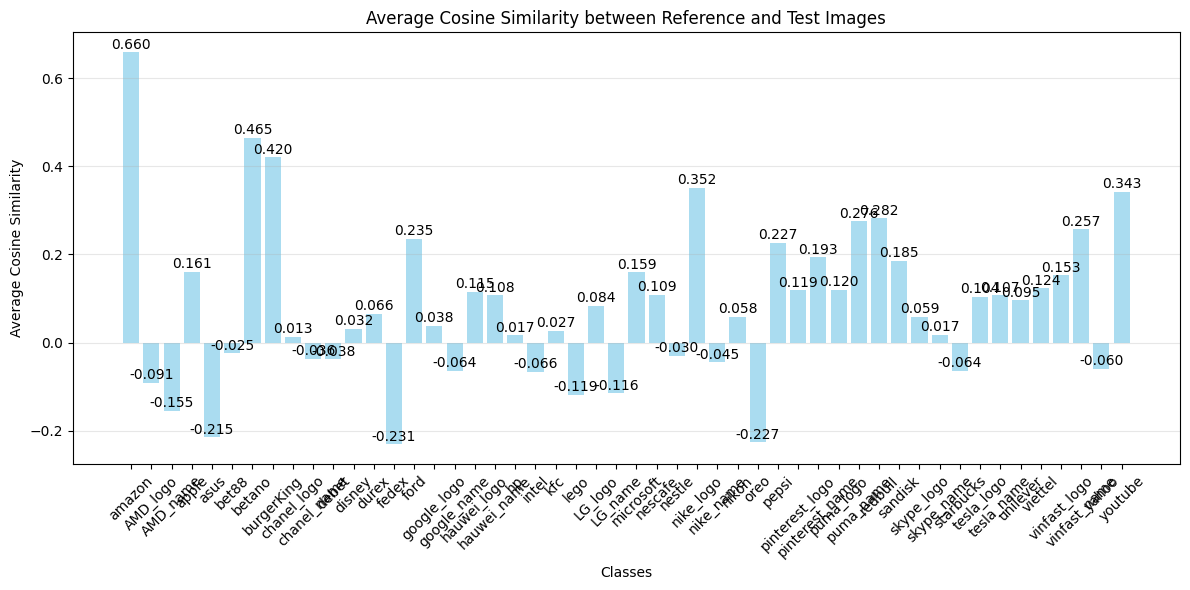

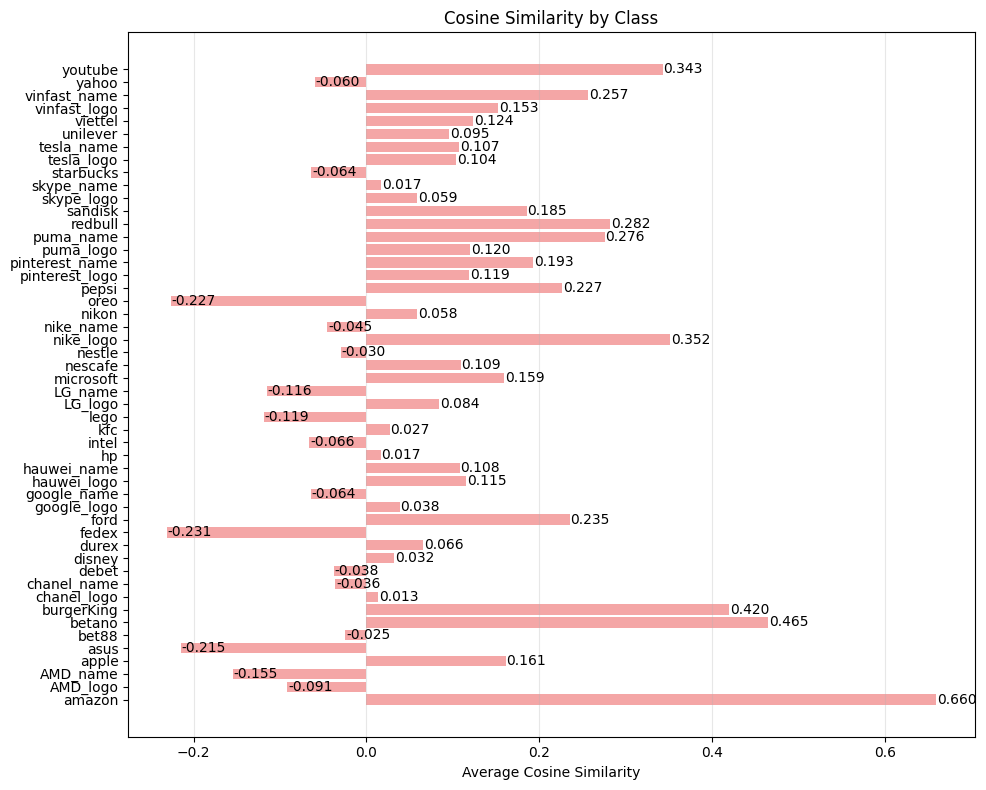

C:\Users\DELL\AppData\Local\Temp\ipykernel_17892\3350221253.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


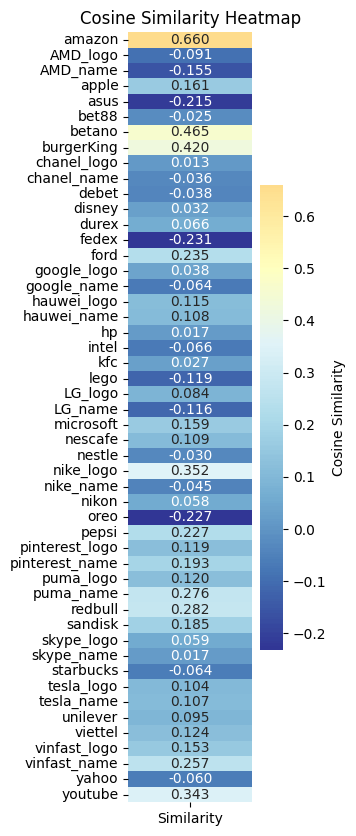

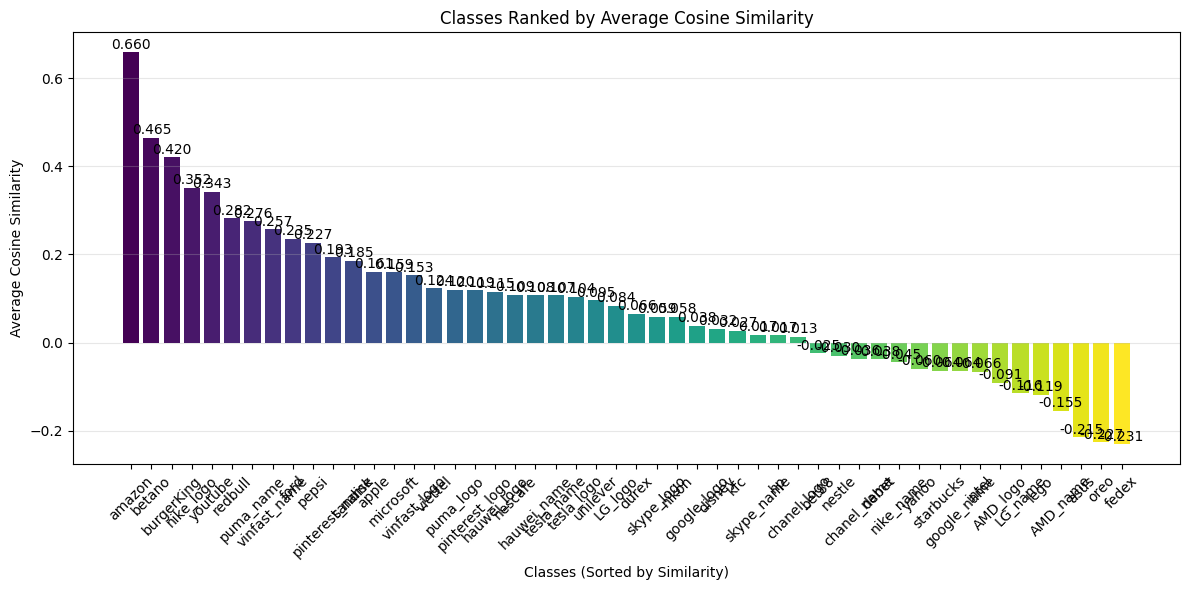


SIMILARITY STATISTICS
Highest similarity: 0.6597 - amazon
Lowest similarity:  -0.2312 - fedex
Average similarity: 0.0840
Standard deviation: 0.1765
Median similarity:  0.0748


In [35]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Lấy tên các folder (class names) để làm label
folder_names = []
for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    if os.path.isdir(folder_path):
        folder_names.append(folder)

print(f"Folders: {folder_names}")
print(f"Number of similarities: {len(list_output)}")

# 1. Bar chart đơn giản
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(list_output)), list_output, color='skyblue', alpha=0.7)
plt.xlabel('Classes')
plt.ylabel('Average Cosine Similarity')
plt.title('Average Cosine Similarity between Reference and Test Images')
plt.xticks(range(len(folder_names)), folder_names, rotation=45)
plt.grid(axis='y', alpha=0.3)

# Thêm giá trị lên đầu mỗi bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{list_output[i]:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 2. Horizontal bar chart để dễ đọc tên class
plt.figure(figsize=(10, 8))
y_pos = np.arange(len(folder_names))
bars = plt.barh(y_pos, list_output, color='lightcoral', alpha=0.7)
plt.yticks(y_pos, folder_names)
plt.xlabel('Average Cosine Similarity')
plt.title('Cosine Similarity by Class')
plt.grid(axis='x', alpha=0.3)

# Thêm giá trị
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2.,
             f'{list_output[i]:.3f}', ha='left', va='center')

plt.tight_layout()
plt.show()

# 3. Heatmap style visualization
plt.figure(figsize=(2, 10))
similarity_matrix = np.array(list_output).reshape(-1, 1)
sns.heatmap(similarity_matrix, 
            yticklabels=folder_names,
            xticklabels=['Similarity'],
            annot=True, 
            fmt='.3f',
            cmap='RdYlBu_r',
            center=0.5,
            cbar_kws={'label': 'Cosine Similarity'})
plt.title('Cosine Similarity Heatmap')
plt.tight_layout()
plt.show()

# 4. Sorted visualization (từ cao đến thấp)
plt.figure(figsize=(12, 6))
sorted_indices = np.argsort(list_output)[::-1]  # Sắp xếp từ cao đến thấp
sorted_similarities = [list_output[i] for i in sorted_indices]
sorted_folders = [folder_names[i] for i in sorted_indices]

bars = plt.bar(range(len(sorted_similarities)), sorted_similarities, 
               color=plt.cm.viridis(np.linspace(0, 1, len(sorted_similarities))))
plt.xlabel('Classes (Sorted by Similarity)')
plt.ylabel('Average Cosine Similarity')
plt.title('Classes Ranked by Average Cosine Similarity')
plt.xticks(range(len(sorted_folders)), sorted_folders, rotation=45)
plt.grid(axis='y', alpha=0.3)

# Thêm giá trị
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{sorted_similarities[i]:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 5. Statistics summary
print("\n" + "="*50)
print("SIMILARITY STATISTICS")
print("="*50)
print(f"Highest similarity: {max(list_output):.4f} - {folder_names[list_output.index(max(list_output))]}")
print(f"Lowest similarity:  {min(list_output):.4f} - {folder_names[list_output.index(min(list_output))]}")
print(f"Average similarity: {np.mean(list_output):.4f}")
print(f"Standard deviation: {np.std(list_output):.4f}")
print(f"Median similarity:  {np.median(list_output):.4f}")

In [38]:
# Phiên bản đơn giản chỉ lấy similarities
simple_results = {}

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    if not os.path.isdir(folder_path):
        continue
    
    # Tìm ảnh reference
    reference_path = None
    for file in os.listdir(folder_path):
        if file.endswith('000000.png') or file.endswith('000000.jpg'):
            reference_path = os.path.join(folder_path, file)
            break
    
    if reference_path is None:
        simple_results[folder] = []
        continue
    
    # Tính similarities
    similarities = []
    all_files = sorted([f for f in os.listdir(folder_path) 
                       if not (f.endswith('000000.png') or f.endswith('000000.jpg'))])
    
    for image_file in all_files:
        test_image_path = os.path.join(folder_path, image_file)
        try:
            cosine_sim = cosine_similarity(reference_path, test_image_path)
            similarities.append(round(cosine_sim, 4))
        except:
            continue
    
    simple_results[folder] = similarities

# In kết quả
for folder, sims in simple_results.items():
    print(f"{folder}: {sims}")

amazon: [0.5634, 0.8774, 0.793, 0.5438, 0.7053, 0.8474, 0.6674, 0.753, 0.5578, 0.4097, 0.6385, 0.3655, 0.8049, 0.8615, 0.3398, 0.8272]
AMD_logo: [0.7274, 0.8586, 0.9538, 0.784, 0.4864, 0.4724, 0.4642, 0.7315, 0.7769, 0.4146]
AMD_name: [0.914, 0.6038, 0.4053, 0.8753, 0.5403, 0.5331, 0.8763, 0.6281, 0.5402, 0.4256]
apple: [0.4173, 0.8643, 0.7668, 0.6447, 0.7939, 0.8782, 0.3069, 0.4723, 0.9586, 0.7323]
asus: [0.7816, 0.4178, 0.5824, 0.7657, 0.6699, 0.5001, 0.523, 0.6715, 0.701, 0.8562, 0.6202, 0.9011, 0.8886, 0.8117, 0.6467]
bet88: [0.4367, 0.4762, 0.0297, 0.4755, 0.9001, 0.6421, 0.26, 0.3268, 0.3943, 0.5755]
betano: [0.9339, 0.9346, 0.7267, 0.6643, 0.6292, 0.8063, 0.163, 0.7764, 0.8674, 0.7039]
burgerKing: [0.9356, 0.8649, 0.9553, 0.9121, 0.4546, 0.939, 0.9233, 0.8661, 0.8707, 0.8834, 0.9198, 0.8946, 0.9267, 0.7506, 0.6974, 0.7728, 0.7851, 0.834, 0.5216, 0.8889, 0.8107, 0.8987]
chanel_logo: [0.9706, 0.9291, 0.4937, 0.8016, 0.9127, 0.6238, 0.8878, 0.5538, 0.887, 0.822]
chanel_name: [0.914

C:\Users\DELL\AppData\Local\Temp\ipykernel_17892\3218274806.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(valid_data, labels=valid_names)


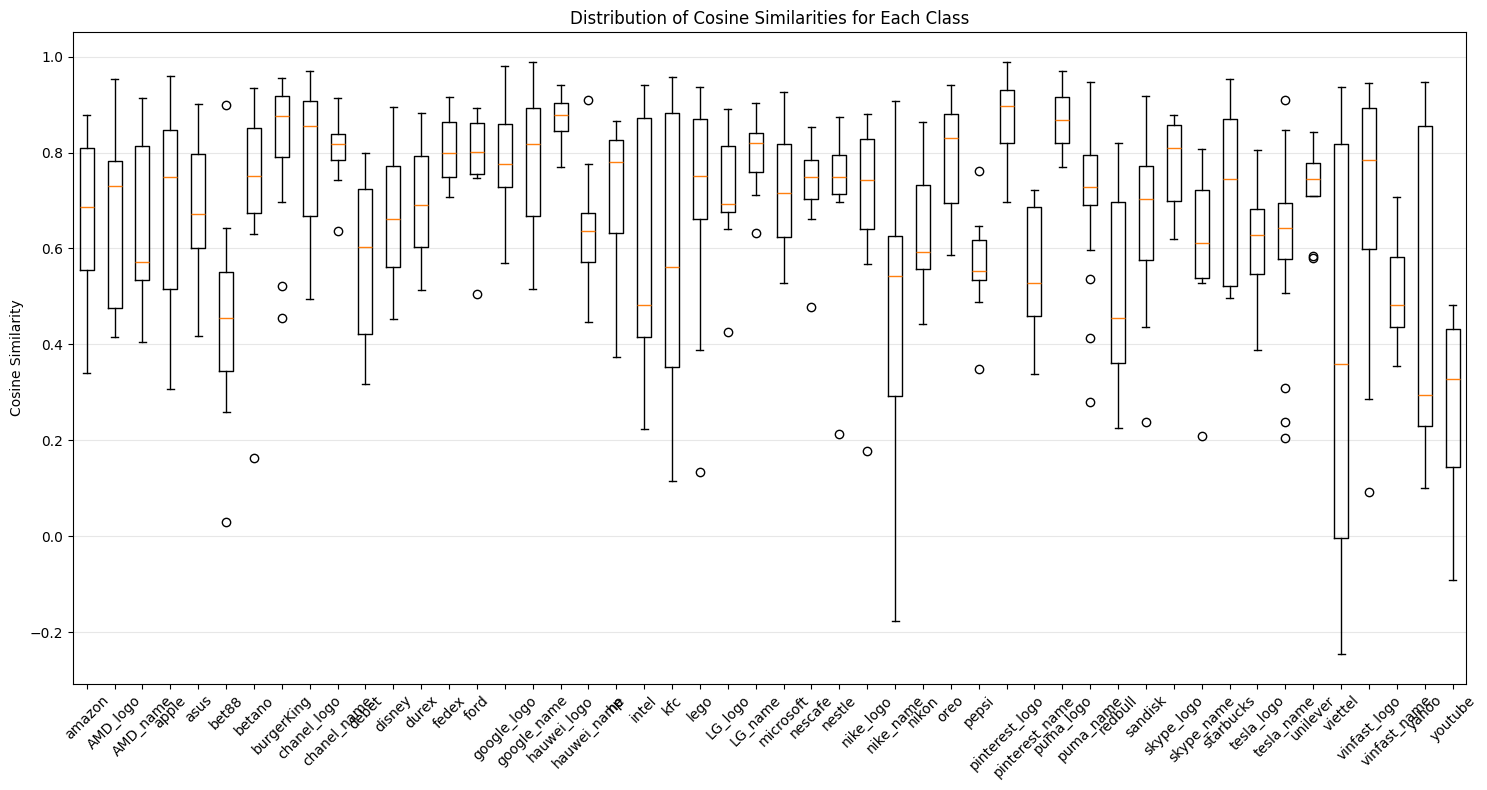

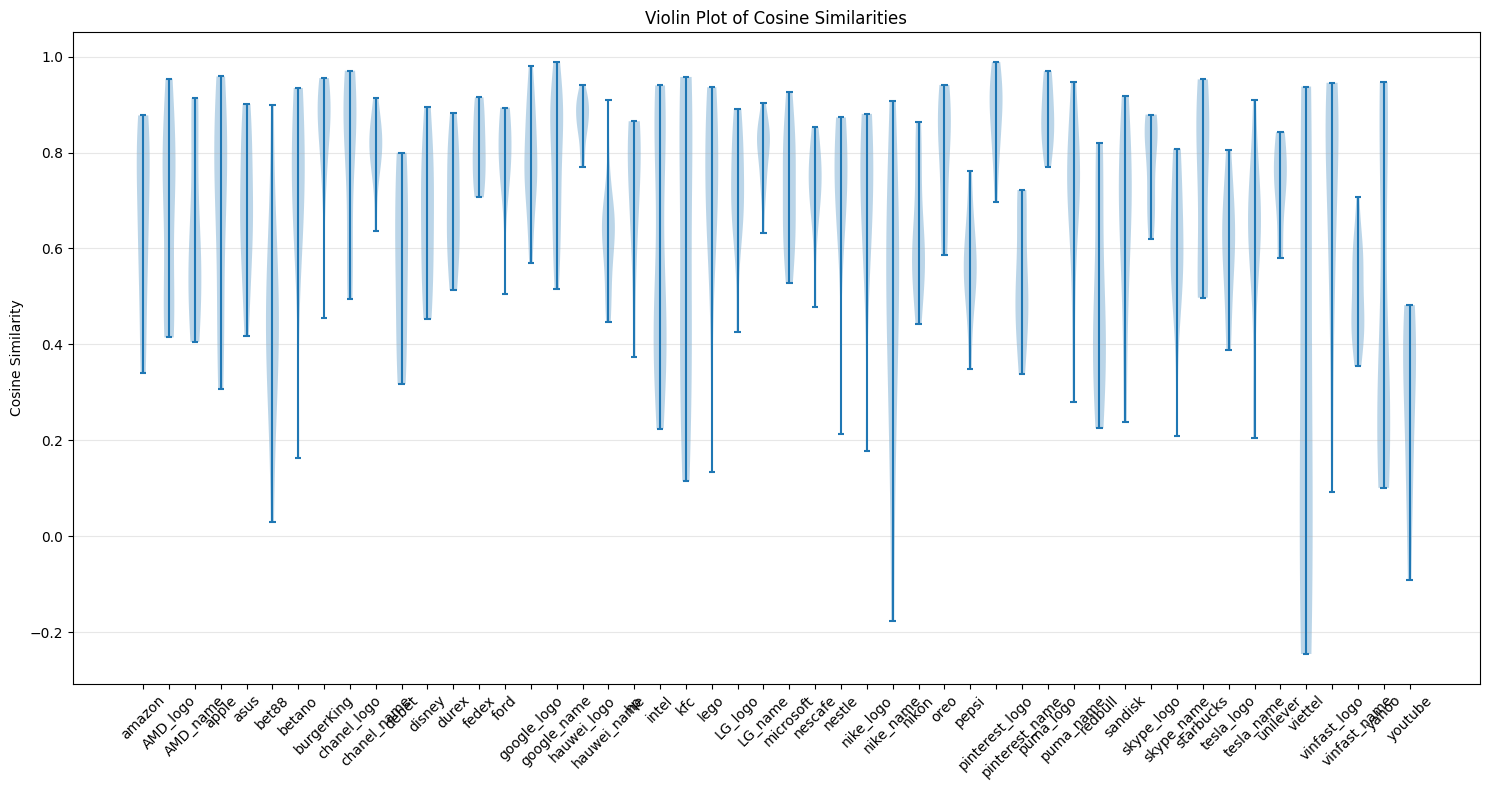

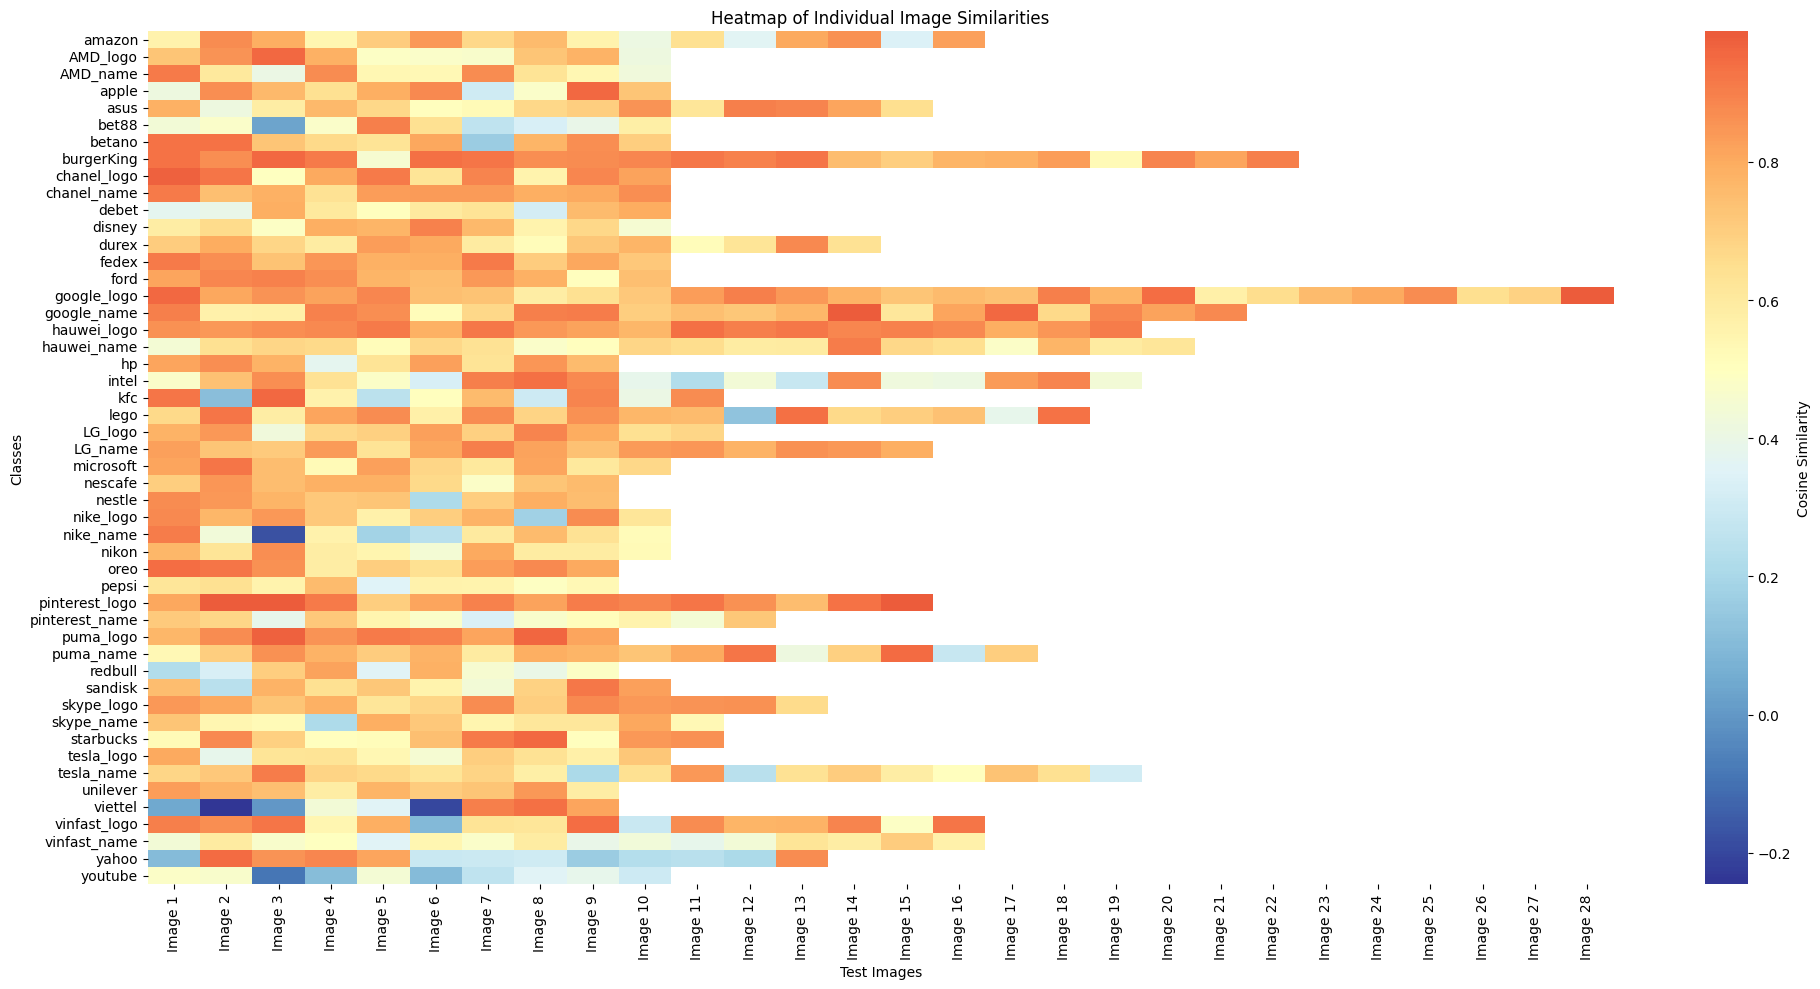

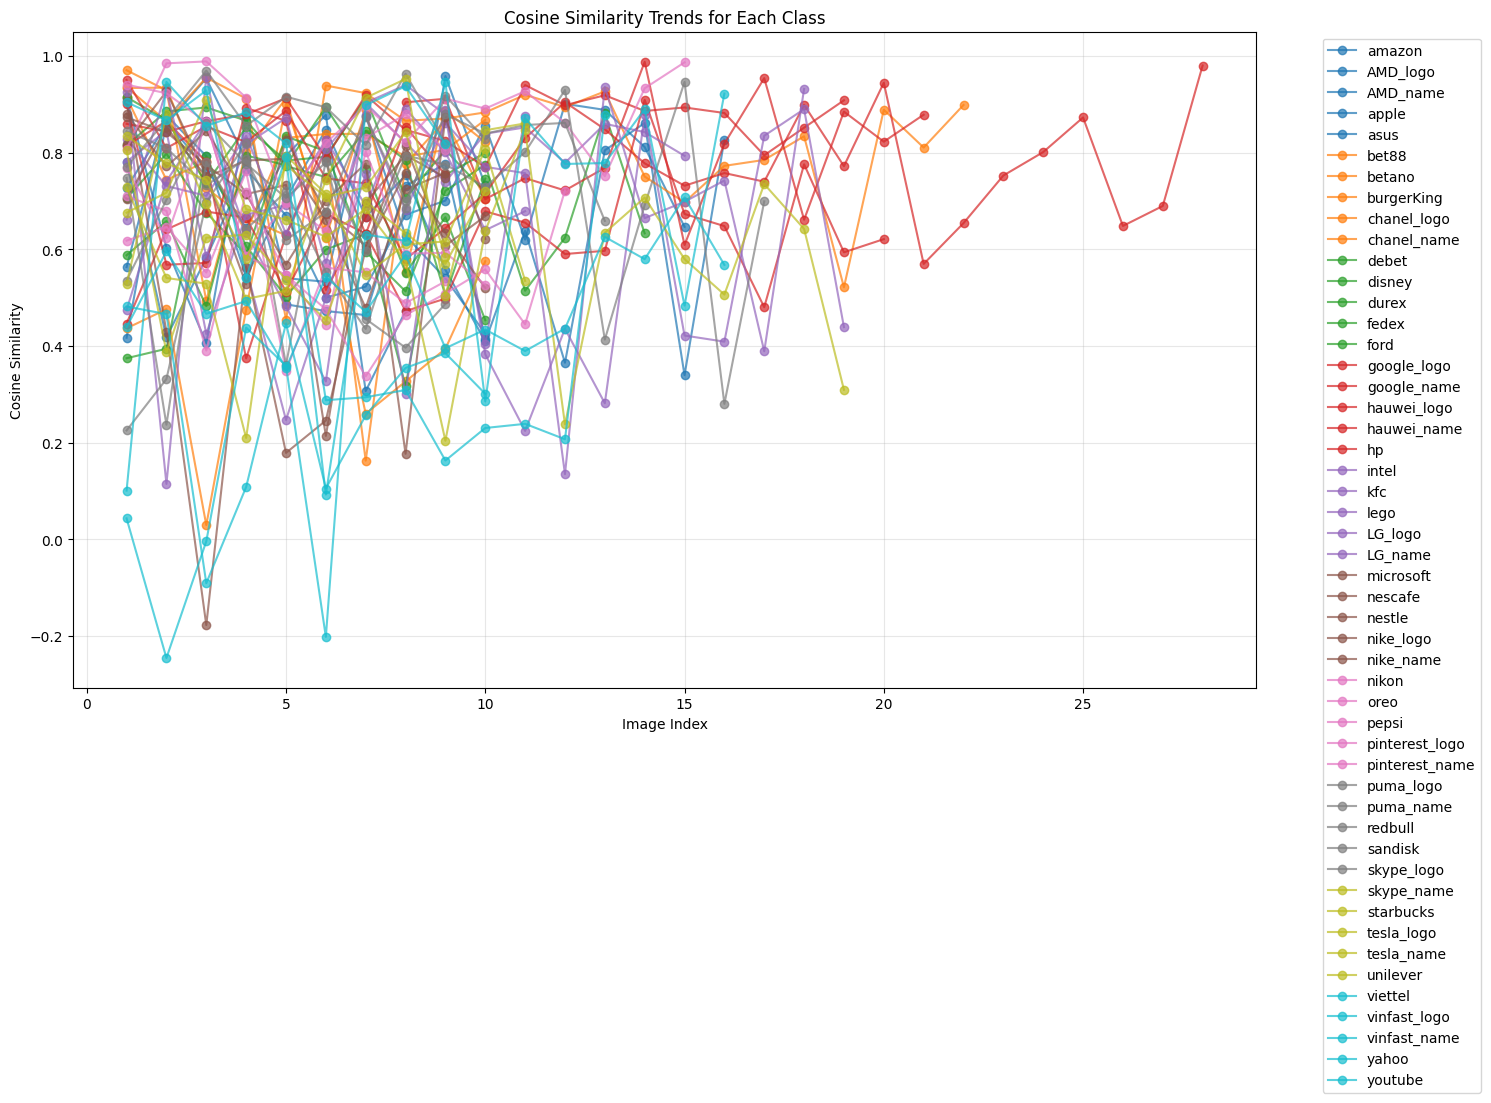

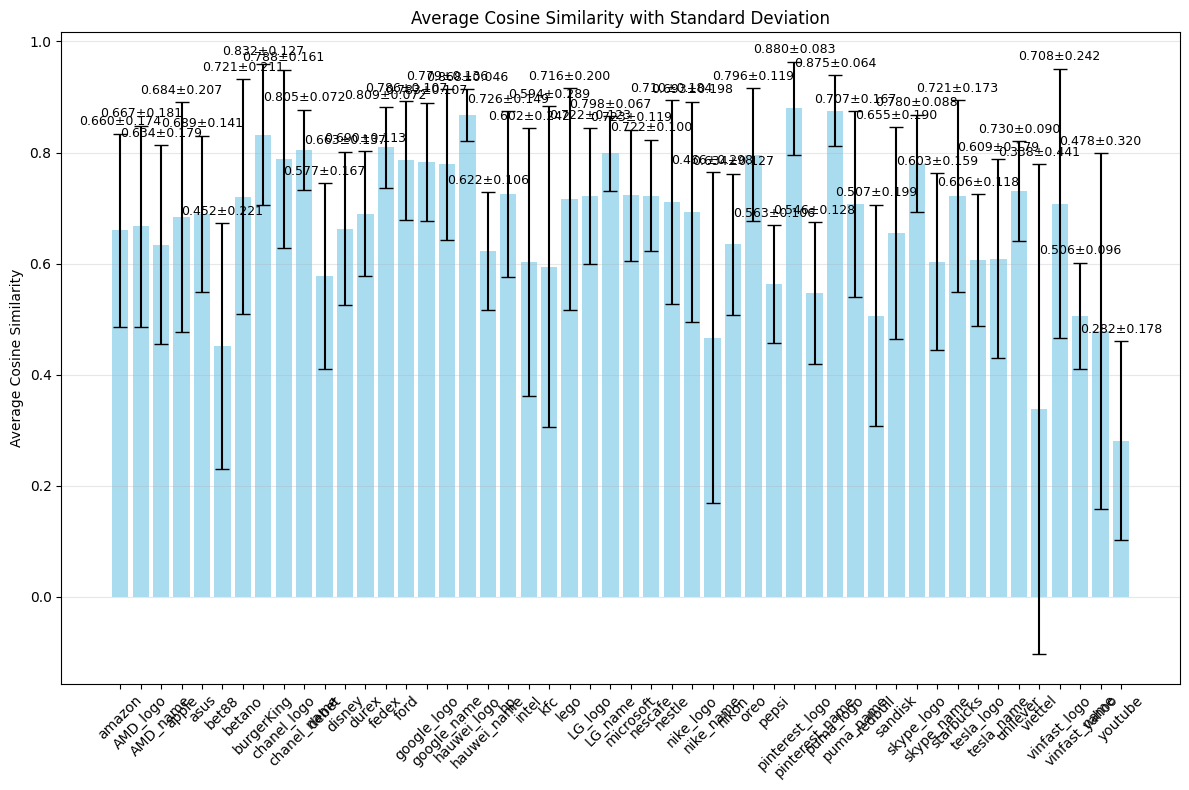

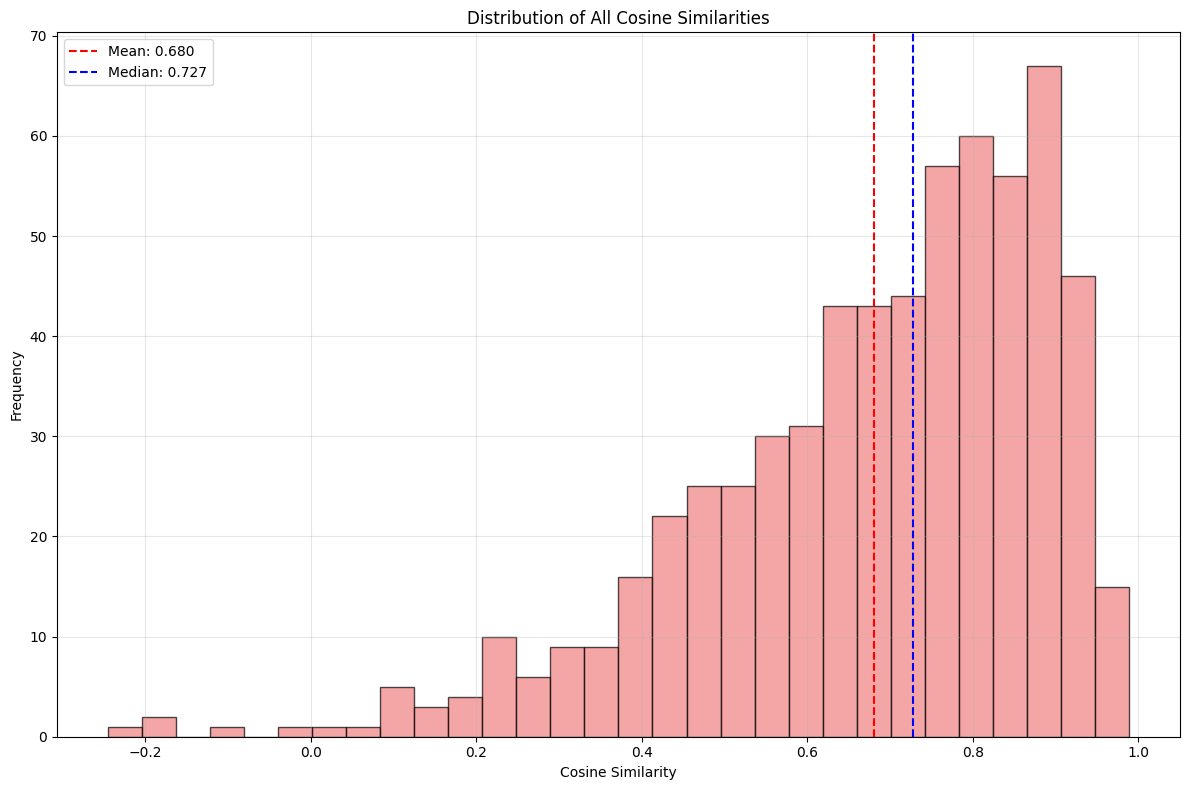

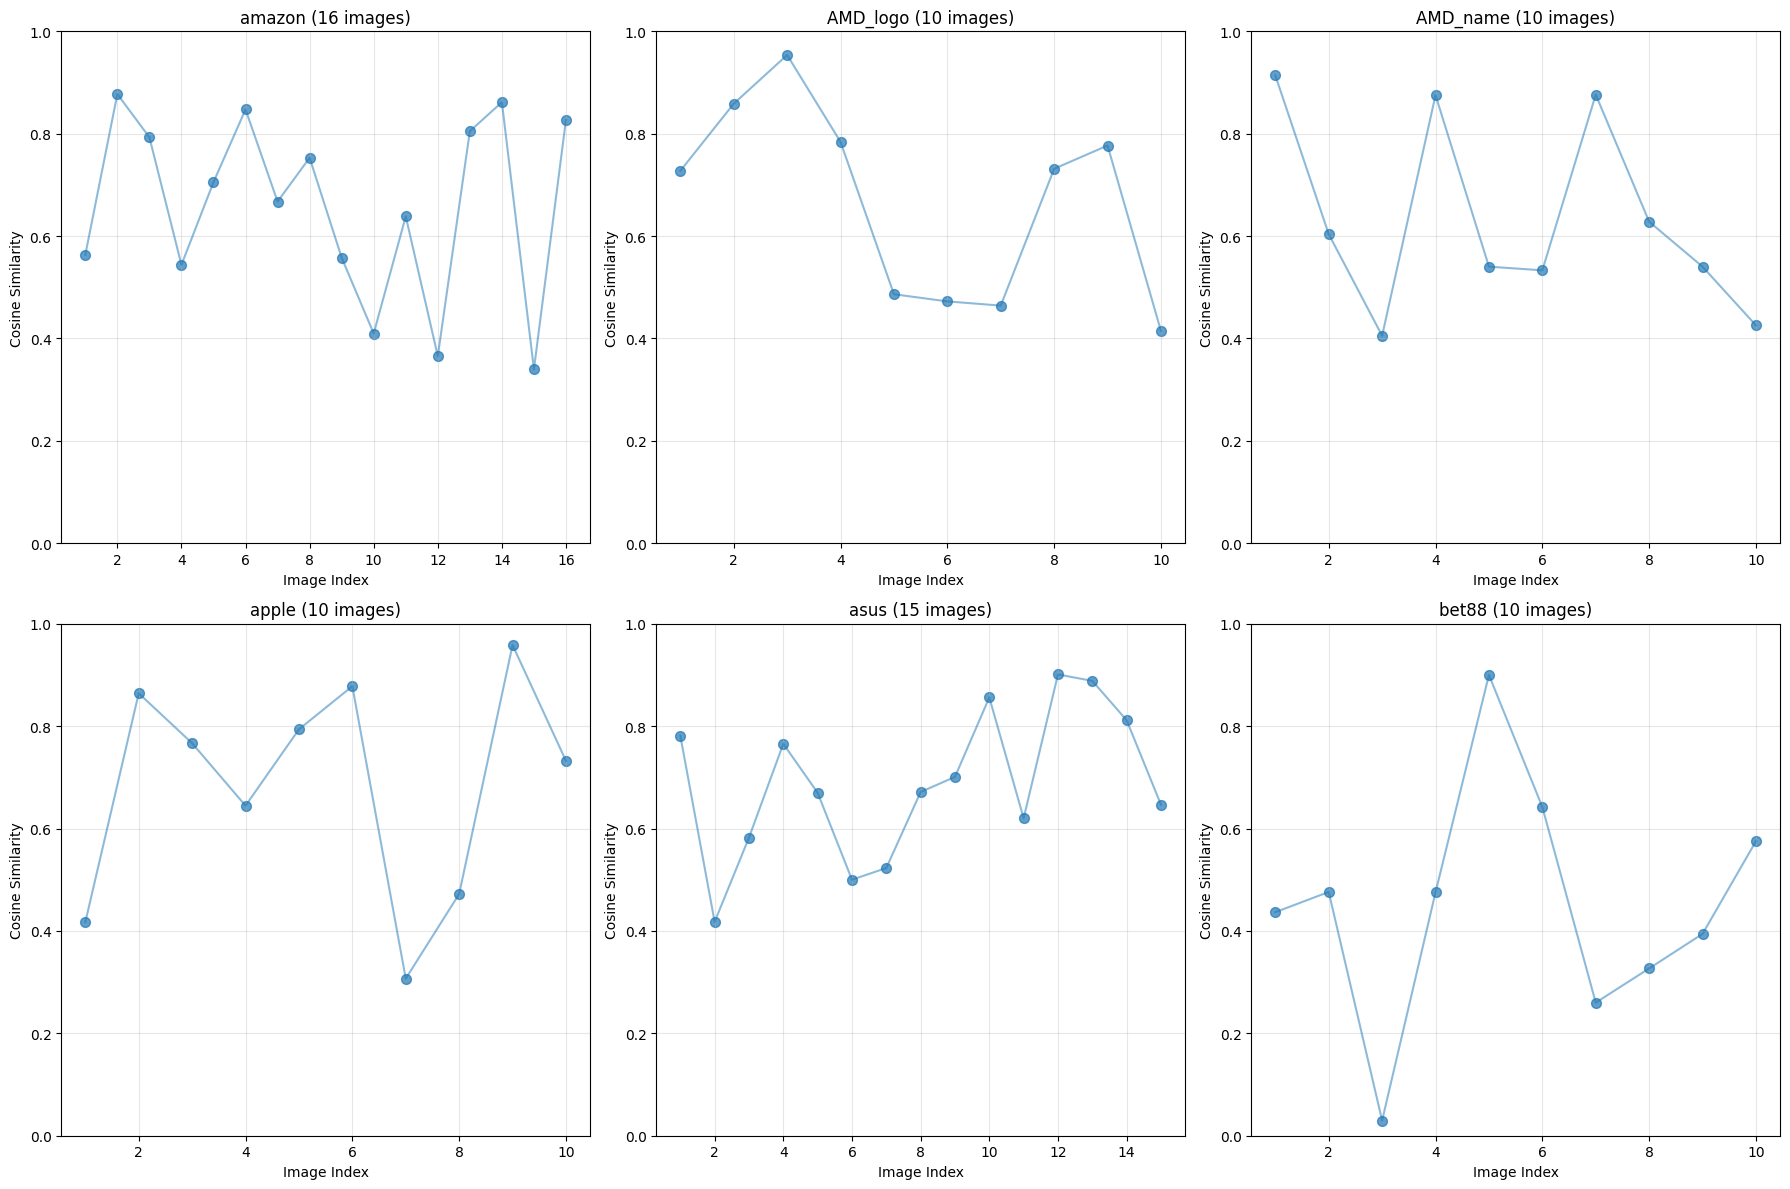


DETAILED STATISTICS

📁 AMAZON:
   Number of images: 16
   Mean: 0.6597
   Median: 0.6864
   Std Dev: 0.1743
   Min: 0.3398
   Max: 0.8774
   Range: 0.5376

📁 AMD_LOGO:
   Number of images: 10
   Mean: 0.6670
   Median: 0.7295
   Std Dev: 0.1811
   Min: 0.4146
   Max: 0.9538
   Range: 0.5392

📁 AMD_NAME:
   Number of images: 10
   Mean: 0.6342
   Median: 0.5720
   Std Dev: 0.1788
   Min: 0.4053
   Max: 0.9140
   Range: 0.5087

📁 APPLE:
   Number of images: 10
   Mean: 0.6835
   Median: 0.7495
   Std Dev: 0.2065
   Min: 0.3069
   Max: 0.9586
   Range: 0.6517

📁 ASUS:
   Number of images: 15
   Mean: 0.6892
   Median: 0.6715
   Std Dev: 0.1409
   Min: 0.4178
   Max: 0.9011
   Range: 0.4833

📁 BET88:
   Number of images: 10
   Mean: 0.4517
   Median: 0.4561
   Std Dev: 0.2209
   Min: 0.0297
   Max: 0.9001
   Range: 0.8704

📁 BETANO:
   Number of images: 10
   Mean: 0.7206
   Median: 0.7515
   Std Dev: 0.2112
   Min: 0.1630
   Max: 0.9346
   Range: 0.7716

📁 BURGERKING:
   Number of images

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 1. Box plot để xem distribution của similarities cho mỗi folder
plt.figure(figsize=(15, 8))
folder_names = list(simple_results.keys())
similarity_data = [simple_results[folder] for folder in folder_names]

# Loại bỏ các folder không có data
valid_data = []
valid_names = []
for i, data in enumerate(similarity_data):
    if len(data) > 0:
        valid_data.append(data)
        valid_names.append(folder_names[i])

plt.boxplot(valid_data, labels=valid_names)
plt.xticks(rotation=45)
plt.ylabel('Cosine Similarity')
plt.title('Distribution of Cosine Similarities for Each Class')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Violin plot cho distribution tốt hơn
plt.figure(figsize=(15, 8))
positions = range(1, len(valid_names) + 1)
parts = plt.violinplot(valid_data, positions=positions)
plt.xticks(positions, valid_names, rotation=45)
plt.ylabel('Cosine Similarity')
plt.title('Violin Plot of Cosine Similarities')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Heatmap của tất cả similarities
plt.figure(figsize=(20, 10))
max_length = max([len(sims) for sims in valid_data])

# Tạo matrix với NaN cho missing values
similarity_matrix = np.full((len(valid_names), max_length), np.nan)
for i, similarities in enumerate(valid_data):
    similarity_matrix[i, :len(similarities)] = similarities

# Mask NaN values
mask = np.isnan(similarity_matrix)
sns.heatmap(similarity_matrix, 
            yticklabels=valid_names,
            xticklabels=[f'Image {i+1}' for i in range(max_length)],
            mask=mask,
            cmap='RdYlBu_r',
            center=0.5,
            cbar_kws={'label': 'Cosine Similarity'})
plt.title('Heatmap of Individual Image Similarities')
plt.xlabel('Test Images')
plt.ylabel('Classes')
plt.tight_layout()
plt.show()

# 4. Line plot cho từng class
plt.figure(figsize=(15, 10))
colors = plt.cm.tab10(np.linspace(0, 1, len(valid_names)))

for i, (folder, similarities) in enumerate(zip(valid_names, valid_data)):
    x_values = range(1, len(similarities) + 1)
    plt.plot(x_values, similarities, 'o-', label=folder, color=colors[i], alpha=0.7)

plt.xlabel('Image Index')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity Trends for Each Class')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Bar chart với error bars (mean ± std)
plt.figure(figsize=(12, 8))
means = [np.mean(sims) for sims in valid_data]
stds = [np.std(sims) for sims in valid_data]

bars = plt.bar(range(len(valid_names)), means, yerr=stds, 
               capsize=5, alpha=0.7, color='skyblue')
plt.xticks(range(len(valid_names)), valid_names, rotation=45)
plt.ylabel('Average Cosine Similarity')
plt.title('Average Cosine Similarity with Standard Deviation')

# Thêm giá trị lên bars
for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + std + 0.01,
             f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=9)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 6. Histogram của tất cả similarities
plt.figure(figsize=(12, 8))
all_similarities = []
for sims in valid_data:
    all_similarities.extend(sims)

plt.hist(all_similarities, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of All Cosine Similarities')
plt.axvline(np.mean(all_similarities), color='red', linestyle='--', 
            label=f'Mean: {np.mean(all_similarities):.3f}')
plt.axvline(np.median(all_similarities), color='blue', linestyle='--', 
            label=f'Median: {np.median(all_similarities):.3f}')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 7. Scatter plot matrix style
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (folder, similarities) in enumerate(zip(valid_names[:6], valid_data[:6])):
    if i < len(axes):
        x_values = range(1, len(similarities) + 1)
        axes[i].scatter(x_values, similarities, alpha=0.7, s=50)
        axes[i].plot(x_values, similarities, '-', alpha=0.5)
        axes[i].set_title(f'{folder} ({len(similarities)} images)')
        axes[i].set_xlabel('Image Index')
        axes[i].set_ylabel('Cosine Similarity')
        axes[i].grid(True, alpha=0.3)
        axes[i].set_ylim(0, 1)

# Ẩn subplot thừa nếu có
for j in range(len(valid_names), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# 8. Statistics Summary
print("\n" + "="*70)
print("DETAILED STATISTICS")
print("="*70)

for folder, similarities in zip(valid_names, valid_data):
    if len(similarities) > 0:
        print(f"\n📁 {folder.upper()}:")
        print(f"   Number of images: {len(similarities)}")
        print(f"   Mean: {np.mean(similarities):.4f}")
        print(f"   Median: {np.median(similarities):.4f}")
        print(f"   Std Dev: {np.std(similarities):.4f}")
        print(f"   Min: {min(similarities):.4f}")
        print(f"   Max: {max(similarities):.4f}")
        print(f"   Range: {max(similarities) - min(similarities):.4f}")

# Overall statistics
print(f"\n📊 OVERALL STATISTICS:")
print(f"   Total images: {sum(len(sims) for sims in valid_data)}")
print(f"   Overall mean: {np.mean(all_similarities):.4f}")
print(f"   Overall median: {np.median(all_similarities):.4f}")
print(f"   Overall std: {np.std(all_similarities):.4f}")
print(f"   Global min: {min(all_similarities):.4f}")
print(f"   Global max: {max(all_similarities):.4f}")